In [1]:
import rebound
import time
import sys
import numpy as np
from matplotlib import pyplot as plt
from astropy import units as u
from astropy import constants as c

# local imports
import heartbeat
import globs
import metasim

In [2]:
def run_sim(filestem='test/test'):
    
    # global variables

    globs.initialise()

    globs.glob_dclo = 1. #CE distance to check in rH
    #dir = 'test/'
    globs.glob_archive = ''
    #globals.glob_names = []
    globs.glob_is_close = False

    system = metasim.MetaSim(filestem=filestem)
    system.run_planets()
    if globs.glob_is_close:
        system.rewind()
        system.add_moons()
        system.run_moons()
        system.analyse()
        system.make_timeline()

Simulation test/test0026

Restored from save


/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulation.py:505: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)
/Users/alexander/research/circumplanetary_discs/rebound/rebound/rebound/simulationarchive.py:146: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


Planet1 bound to EPIC220208795: a=1.36114303681754 e=0.3043804059603079
Planet2 bound to EPIC220208795: a=3.1567645846419476 e=0.31932471803786894
Europa1 bound to Galaxy: a=-1.6702361023117998 e=6.235892782827845
Io2 bound to EPIC220208795: a=1.0712064655568465 e=0.05163097123292149
Europa2 bound to EPIC220208795: a=2.164879109133929 e=0.39118498194011503
('Io1', 'Planet1')
(0.10035755243573659, 0.18888888888888888)
black
('Callisto2', 'Planet1')
(0.10035835904205596, 0.3666666666666667)
black
('Ganymede1', 'Planet1')
(0.10035840577737108, 0.2777777777777778)
black
('Callisto1', 'Planet2')
(0.10043079927244981, 0.7027777777777778)
gainsboro
('Ganymede2', 'EPIC220208795')


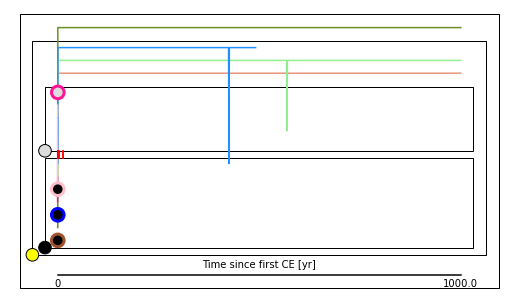

In [3]:
#Nsys = 1

#for i in range(Nsys):
#    run_sim(filestem=f'test/test{i:04d}')

i = 26
run_sim(filestem=f'test/test{i:04d}')